Parameters: lematizer = spacy, vectorizer = bow, ngram = unigram, classifier = multinomial


col_0         0         1         2         3
row_0                                        
0      0.832378  0.051576  0.070201  0.045845
1      0.090247  0.758370  0.081514  0.069869
2      0.107389  0.066010  0.790148  0.036453
3      0.042636  0.077519  0.058140  0.821705
Vidutinis training score: 0.9107452339688041
Vidutinis testing score: 0.800252047889099



Parameters: lematizer = spacy, vectorizer = bow, ngram = bigram, classifier = multinomial


col_0         0         1         2         3
row_0                                        
0      0.393855  0.068436  0.505587  0.032123
1      0.060519  0.260807  0.635447  0.043228
2      0.022417  0.023392  0.942495  0.011696
3      0.028455  0.046070  0.677507  0.247967
Vidutinis training score: 0.9594296518040019
Vidutinis testing score: 0.5081915563957152



Parameters: lematizer = spacy, vectorizer = bow, ngram = unigram-bigram, classifier = multinomial


col_0         0         1         2         3
row_0                                        
0      0.813822  0.076164  0.077574  0.032440
1      0.145892  0.698300  0.076487  0.079320
2      0.098923  0.062684  0.795299  0.043095
3      0.056911  0.048780  0.055556  0.838753
Vidutinis training score: 0.9612415314321727
Vidutinis testing score: 0.7879647132955262



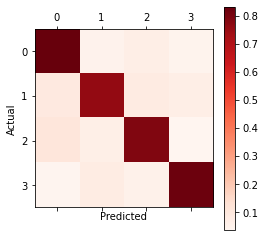

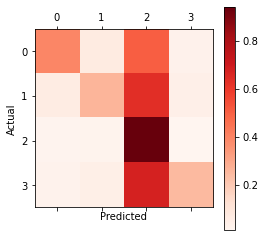

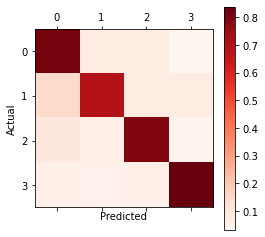

In [8]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
import nltk


import pandas as pd
import string
import spacy
from spacy.lang.lt.stop_words import STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

def text_processing(text):
     # 1. Skyrybos ženklų šalinimas
    nopunct=[char for char in text if char not in string.punctuation]
    nopunct=''.join(nopunct)
    nopunct = ' '.join(nopunct.split())
    #Lemavimas
    doc = nlp(nopunct)
    string1=''
    for word in doc:
        string1+=word.lemma_+ ' '
    string1=string1[:-1]
    # 3. "Stop" žodžių šalinimas
    doc = nlp(string1)
    return [word.text.lower() for word in doc if not word.is_stop]


def text_preprocessor(text):
    nopunct = [char for char in text if char not in string.punctuation]
    nopunct = ''.join(nopunct)
    nopunct = ' '.join(nopunct.split())

    # Lemmatising
    doc = nlp(nopunct)
    string1 = ''
    for word in doc:
        string1 += word.lemma_ + ' '
    return string1


def label_encoding(data):
    y = data['Author']
    labelencoder = LabelEncoder()
    y = labelencoder.fit_transform(y)
    return y
    

def word_cloud_visualisation(data,X):
    wordcloud1 = WordCloud().generate(X[1]) # Biliunas
    wordcloud2 = WordCloud().generate(X[900]) # Zemaite
    wordcloud3 = WordCloud().generate(X[301]) # Donelaitis
     
    print(X[1])
    print(data['Author'][1])
    plt.imshow(wordcloud1, interpolation='bilinear')
    plt.show()
    print(X[900])
    print(data['Author'][900])
    plt.imshow(wordcloud2, interpolation='bilinear')
    plt.show()
    print(X[301])
    print(data['Author'][301])
    plt.imshow(wordcloud3, interpolation='bilinear')
    plt.show()


def model_trainning(text_bow_train, y_train, classifier):
    model = classifier
    model = model.fit(text_bow_train, y_train)
    return model


def show_confusion_matrix(y_test, predictions):
    matrix = pd.crosstab(y_test,predictions)
    #matrix = confusion_matrix(y_test,predictions)
    norm_matrix = matrix/matrix.sum(axis = 1)[:,np.newaxis]
    print (norm_matrix)
    plt.matshow(norm_matrix, cmap=plt.cm.Reds)
    plt.colorbar()
    plt.ylabel("Actual")
    plt.xlabel("Predicted")


for m in ('spacy',):
    method = 'spacy'  # input('Kokus lematizuotus naudoti? {spacy, lkssais}')
    for v in ('bow',):
        vectorizer_input = v  # input('bow - naudoti bag of words, kita - naudoti TF-IDF')
        spacy_stopwords = spacy.lang.lt.stop_words.STOP_WORDS
        all_ngrams = ('none',)
        if vectorizer_input == 'bow':
            all_ngrams = ('unigram', 'bigram', 'unigram-bigram')
        
        for ng in all_ngrams:
            if vectorizer_input == 'bow':
                ngram = ng  # input('{unigram, bigram, unigram-bigram')
                if ngram == 'unigram':
                    ngram = (1, 1)
                elif ngram == 'bigram':
                    ngram = (2, 2)
                else:
                    ngram = (1, 2)
            
            for cl in ('multinomial',):
                classifier = cl  # input('{multinomial, svc}')
                if classifier == 'multinomial':
                    classifier = MultinomialNB()
                else:
                    classifier = LinearSVC()
                
                data = pd.read_csv(f'./root/{method}.csv')
                nlp = spacy.load('lt_core_news_sm')
                
                print(f"Parameters: lematizer = {m}, vectorizer = {v}, ngram = {ng}, classifier = {cl}")
                
                score_sum = 0
                test_score_sum = 0
                iter_count = 1
                
                for i in range(0, iter_count):
                
                    X = data['Text']
                    y = label_encoding(data)
                    # word_cloud_visualisation(data,X)
                    # Splitting data into testing and training data
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
                    if vectorizer_input == 'bow':
                        vectorizer = CountVectorizer(ngram_range=ngram, stop_words=spacy_stopwords)
                    else:
                        vectorizer = TfidfVectorizer()
                    text_bow_train = vectorizer.fit_transform(X_train)
                    text_bow_test = vectorizer.transform(X_test)
                    # print(bow_transformer.get_feature_names())
                    # print(text_bow_train.toarray())
                    
                    model = model_trainning(text_bow_train, y_train, classifier)
                    
                    # model.predict(text_bow_test)
                    predictions = model.predict(text_bow_test)
                    show_confusion_matrix(y_test, predictions)
                    score_sum += model.score(text_bow_train, y_train)
                    test_score_sum += model.score(text_bow_test, y_test)
                
                print(f'Vidutinis training score: {score_sum / iter_count}')
                print(f'Vidutinis testing score: {test_score_sum / iter_count}')
                print()








